# The Quantum Sawtooth Map

Quantum maps, the quantum analogs of classical maps, are simple yet powerful models of quantum dynamics. Over the years, these toy models have played an important role in understanding fundamental phenomena such as the correspondence principle, decoherence, entanglement spreading, and quantum dynamical chaos. In the context of *quantum computing*, these well-studied systems provide a convenient and nontrivial testbed for quantum algorithms and hardware. Their dynamics are rich enough to generate strong entanglement and chaotic behavior, yet structured enough to admit efficient implementations on quantum circuits. As a result, quantum maps have been used as controlled settings to investigate the effects of noise, imperfections, and decoherence in quantum processors, as well as to assess hardware performance. For example, quantum chaotic maps have been employed to study the impact of realistic noise models on quantum dynamics [[1](#PorterJoseph)]  and to benchmark quantum hardware through their sensitivity to errors and entanglement generation [[2](#Pizzamiglio_etal)].

A typical quantum map describes a system undergoing free evolution that is periodically “kicked” by a position-dependent force. The resulting dynamics are discrete in time and are naturally formulated as a so-called Floquet system [[3](#Floquet)]. Most quantum maps are obtained by quantizing a known classical map, such as the tent map, the sawtooth map, or the kicked rotor, allowing for direct comparison between classical and quantum behavior.


Despite their simple definition, quantum maps can exhibit chaotic dynamics accompanied by rapid entanglement growth, which makes their classical simulation inefficient. Since these models are well understood, quantum simulations at currently accessible system sizes are not expected to reveal new physical phenomena. Nevertheless, quantum maps remain a valuable theoretical and algorithmic framework, and future applications may emerge as larger-scale quantum simulations become possible.

In this notebook we focus on the quantum sawtooth map and the phenomenon of dynamical localization, whose validation on quantum hardware has been studied in several previous works (see Refs. in [[1](#PorterJoseph)]). Below, we define the model and discuss its theoretical properties, as well as present execution results on an IonQ machine.

**This notebook illustrates how Classiq Qmod’s language and execution framework can be used to easily define, run, and observe quantum phenomena on a real quantum device**.

## Quantum Sawtooth Map and its Evolution

### The system Hamiltonian

We start with the classical sawtooth map, written in terms of the action-angle variables $(p,q)$
$$
\large
H_{\rm cl}(t) = \frac{p^2}{2L}-K\frac{q^2}{2}\sum_{i}\delta(t-i\tau), \quad q \bmod 2\pi,
$$
where $L$ is the moment of inertia, and $K$ and $\tau$ are the kicking strength and kicking period, respectively.

We now skip directly to the quantum model; the full derivation is provided in the Technical Notes at the end of this notebook. The derivation includes a straightforward quantization procedure, together with several redefinitions and normalizations. For the quantum map, we consider a finite Hilbert space of dimension $N$, with momentum and position operators $\hat{p}$ and $\hat{q}$ defined by
$$
\hat{p}|p\rangle = p|p\rangle,\qquad \hat{q}|q\rangle = q|q\rangle,
\qquad p,q \in \left\{\frac{N}{2}, \dots,-1,0,1, \dots,\frac{N-1}{2}\right\}.
$$
The Hamiltonian of the quantum sawtooth map reads:
$$
\large
\frac{H_N(t)}{\hbar} = 2\pi \left(\frac{\hat{p}^2}{2N}-K\frac{\hat{q}^2}{2N}\sum_{i}\delta(t-i)\right),
$$
where $\hbar$ is a dimensionless Planck constant (which can be related to the physical one by a factor of $L/\tau$).
As part of the quantization procedure, the product $\hbar N$ is held constant. Consequently, the parameter controlling quantum effects is the Hilbert space dimension $N$, with quantum fluctuations scaling as $\hbar \sim 1/N$.

### The time evolution

A key practical advantage of quantum maps is the simplicity of their implementation on a quantum computer. The time-evolution operator can often be decomposed into a sequence of evolutions generated by operators that are diagonal in complementary bases. In particular, for the sawtooth map considered in this notebook, the implementation does not require approximation overhead from product formulas or Chebyshev expansions, making it especially well suited for near-term quantum devices.

The unitary evolution of the system between kick $t$ and $t+1$, known as the Floquet operator, is given by:
$$
\large
|\psi_{t+1}\rangle = U_{\rm kick}|\psi_{t}\rangle,\qquad
U_{\rm kick} \equiv \exp\left[-i\frac{2\pi}{N} \frac{\hat{p}^2}{2}\right] 
 \exp\left[iK\frac{2\pi}{N} \frac{\hat{q}^2}{2}\right].
$$
The evolution of the system from an initial state after $T$ kicks is therefore
$$
\large
U(T - {\rm kicks}) = U^T_{\rm kick} = \left(\exp\left[-i\frac{2\pi}{N} \frac{\hat{p}^2}{2}\right] 
 \exp\left[iK\frac{2\pi}{N} \frac{\hat{q}^2}{2}\right]\right)^T.
$$
The kinetic term is diagonal in the momentum basis, while the kicking term is diagonal in the position basis.
Since the two bases are related by a (discrete) Fourier transform, the Floquet operator can be efficiently
simulated by alternating between these representations.

### Implementation in Qmod
We work with a Hilbert space of $n$ qubits, corresponding to a dimension $N=2^n$.
The time evolution of the model can be written in Qmod using only a few lines of code, taking advantage of the phase assignment construct.

In [1]:
from classiq import *
from classiq.qmod.symbolic import pi


@qfunc
def pspace_evolution(p: QNum):
    phase(p**2 / 2, -2 * pi / 2**p.size)


@qfunc
def qspace_evolution(kick_mag: CReal, p: QNum):
    within_apply(
        lambda: qft(p), lambda: phase(p**2 / 2, (2 * pi / (2**p.size)) * kick_mag)
    )


@qfunc
def single_step(kick_mag: CReal, p: QNum):
    qspace_evolution(kick_mag, p)
    pspace_evolution(p)

## Dynamical Localization

Depending on the non-dimensional parameters $N$ and $K$, the quantum system exhibits different dynamical regimes and a variety of phenomena, such as dynamical localization, anomalous diffusion, and a positive quantum Lyapunov exponent. In this notebook we focus on the regime $0<K<1$, in which dynamical localization can be observed (we refer to the literature, e.g., Ref. [[1](#PorterJoseph)], for the full plethora of possible behaviors).

For $0<K<1$,starting from a single excited momentum eigenstate $|p(0)\rangle = |p_0\rangle$, the wavefunction initially diffuses classically in momentum space, until quantum effects become relevant. This occurs at the Heisenberg time, defined as the time required to resolve the energy levels of the system. Beyond this time scale, quantum interference suppresses diffusion and leads to localization of the wavefunction over long times,
$$
\left|\langle p|\psi\rangle\right|^2 \sim \frac{1}{\ell}e^{-2|p-p_0|/\ell},
$$
with localization length $\ell\approx 3.3 K^{5/2}N^2/(2\pi)^2$. Since we consider a finite Hilbert space, localization persists only for a finite time and is observable provided that the localization length is smaller than the system size, $\ell<N$. This condition is satisfied as long as
$$
K<K_{\rm loc} \approx \pi N^{-2/5}.
$$

## Example: Localization in a 3 qubits System


We choose some hyper parameters, looking at a system on 3 qubits.

In [2]:
import numpy as np

NUM_QUBITS = 3
hilbert_size = 2**NUM_QUBITS
k_loc = np.pi * hilbert_size ** (-2 / 5)
print(f"Kicking magnitude must be smaller than K={k_loc}")

KICK_MAG = 0.1
print(f"Taking K = {KICK_MAG}")
loc_len = 3.3 * KICK_MAG ** (5 / 2) * (hilbert_size / 2 * np.pi) ** (2)
assert (
    loc_len < hilbert_size
), "Localization length {loc_len} must be smaller than system size"
print(f"Localization length:  {loc_len}")

Kicking magnitude must be smaller than K=1.3674576271147798
Taking K = 0.1
Localization length:  1.64791067824756


### Model definition

Defining a model with a parametric number of total time (number of kicks $T$):

In [3]:
@qfunc
def main(num_kicks: CInt, kick_mag: CReal, p: Output[QNum[NUM_QUBITS, SIGNED, 0]]):
    allocate(p)
    p ^= -2
    power(num_kicks, lambda: single_step(KICK_MAG, p))


qprog = synthesize(main)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/39QGJm2iW8Op1QhOKzh8QDnt5tp


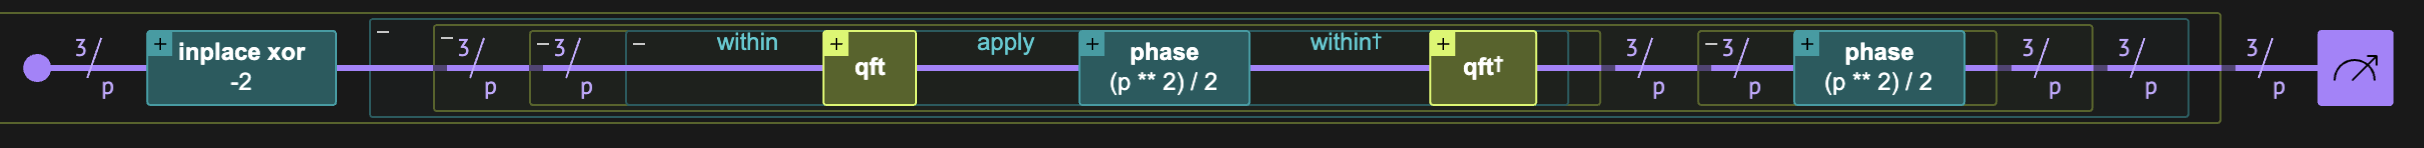

In [4]:
depth = qprog.transpiled_circuit.depth
cx_counts = qprog.transpiled_circuit.count_ops["cx"]
print(f"depth for one iteration {depth}")
print(f"cx counts for one iteration {cx_counts}")

depth for one iteration 49
cx counts for one iteration 30


### Execution

We execute the quantum program for different total numbers of kicks in order to examine the time evolution of the initial wavefunction.

In [5]:
NUM_TIMES = 4
timesteps = [2 * i for i in range(1, NUM_TIMES + 1)]

In [6]:
print(f"======== Running for {len(range(1,NUM_TIMES+1))} different times =========")
print(f"times : {timesteps}")
print(f"depths per power execution {[depth*2*i for i in range(1,NUM_TIMES+1)]}")
cxs = [cx_counts * 2 * i for i in range(1, NUM_TIMES + 1)]
print(f"cx-counts per power execution  {cxs}")
print(f"Total cx counts {sum(cxs)}")

======== Running for 4 different times =========
times : [2, 4, 6, 8]
depths per power execution [98, 196, 294, 392]
cx-counts per power execution  [60, 120, 180, 240]
Total cx counts 600


First, we run the circuit on a simulator to obtain a reference for the expected dynamics.

In [7]:
NUM_SHOTS = 1000

In [8]:
backend_preferences = ClassiqBackendPreferences(
    backend_name="simulator",
)
execution_prefs = ExecutionPreferences(
    backend_preferences=backend_preferences, num_shots=NUM_SHOTS
)

with ExecutionSession(qprog, execution_prefs) as es:
    results_simulator = es.batch_sample([{"num_kicks": t} for t in timesteps])

When running on hardware, we submit a job and store its ID. The results can then be retrieved once the execution is complete.

In [9]:
import datetime
import os

BACKEND_NAME = "qpu.forte-1"
RUN_ON_HARDWARE = False

if RUN_ON_HARDWARE:
    # Define backend preferences

    backend_preferences = IonqBackendPreferences(
        backend_name=BACKEND_NAME, run_through_classiq=True, error_mitigation=False
    )

    prefix = f"{BACKEND_NAME}_{NUM_SHOTS}"
    execution_prefs = ExecutionPreferences(
        backend_preferences=backend_preferences, num_shots=NUM_SHOTS
    )
    # Submit a job
    with ExecutionSession(qprog, execution_prefs) as es:
        job = es.submit_batch_sample([{"num_kicks": t} for t in timesteps])
        job_ID = job.id
        print(f"Job ID: {job_ID}")
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{prefix}_jobID_{timestamp}.txt"

        with open(filename, "w") as f:
            f.write(job_ID)

In [10]:
# Check job status
if RUN_ON_HARDWARE:
    with open(filename, "r") as f:
        job_ID = f.read()

    restored_job = ExecutionJob.from_id(job_ID)
    status = restored_job.status
    print(f"Job status: {status}")

    if status == "COMPLETED":
        res = restored_job.get_batch_sample_result()
        dirname = f"data_{prefix}_jobID_{timestamp}"
        os.makedirs(dirname, exist_ok=True)

        for i, df in enumerate(res):
            df = res[i].dataframe
            df.to_csv(f"{dirname}/df_{timesteps[i]}kicks.csv", index=False)

Below, we load pre-run results obtained on IonQ machines and compare them to the simulator results:

In [11]:
dirname = "data_qpu.forte-enterprise-1_1000_jobID_20251225_122229"

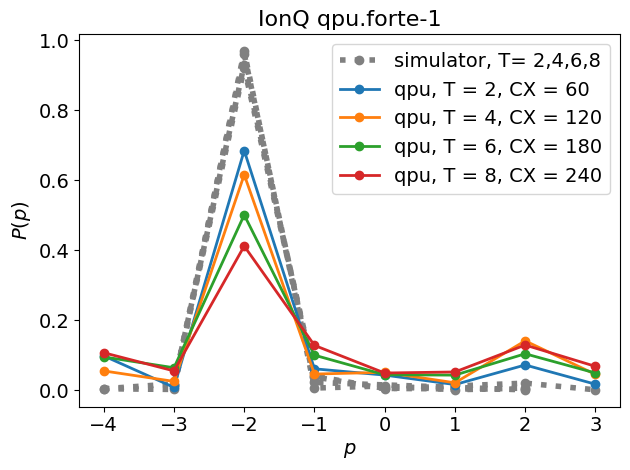

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(
    # figsize=(12, 4),
    # sharey=True
)

# Simulator
for i in range(len(timesteps)):
    df = results_simulator[i].dataframe
    df_sorted = df.sort_values("p")
    cl_plot = axes.plot(
        df_sorted["p"], df_sorted["probability"], ":o", color="gray", linewidth=4
    )

axes.tick_params(axis="both", labelsize=14)
pl_objs = []
for i in range(len(timesteps)):
    df = pd.read_csv(f"{dirname}/df_{timesteps[i]}kicks.csv")
    df_sorted = df.sort_values("q")
    pl_objs += axes.plot(df_sorted["q"], df_sorted["probability"], "-o", linewidth=2)

axes.legend(
    cl_plot + pl_objs,
    ["simulator, T= 2,4,6,8"]
    + [f"qpu, T = {timesteps[i]}, CX = {cxs[i]}" for i in range(len(timesteps))],
    fontsize=14,
)
axes.set_title(f"IonQ {BACKEND_NAME}", fontsize=16)
axes.set_xlabel(r"$p$", fontsize=14)
axes.set_ylabel(r"$P(p)$", fontsize=14)

plt.tight_layout()
plt.show()

## Technical Notes

Below we derive the time-evolution of the quantum sawtooth map. We start with the classical map and go through several renormalizations and redefinitions.
The classical system is written for the so-called action-angle variables $(p,q)$
$$
\large
H_{\rm cl}(t) = \frac{p^2}{2L}-K\frac{q^2}{2}\sum_{i}\delta(t-i\tau), \quad q \bmod 2\pi,
$$
where $L$ is the momentum of inertia, and $K$ and $\tau$ are the kicking strength and period, respectivaly.
We move to a non-dimentional problem, by taking $t\rightarrow t\tau$, and $p\rightarrow pL/\tau$
$$
\large
H_{\rm cl}(t) = \frac{p^2}{2}-K\frac{q^2}{2}\sum_{i}\delta(t-i), \quad q \bmod 2\pi,
$$
where we also define $K\rightarrow K\tau/L$.
Next, we quantize the system, defining the operators $\hat{p}$ and $\hat{q}$ on a finite Hilbert space of size $N$ with
$$
\hat{p}|n\rangle = \hbar|n\rangle, \quad [\hat{p},\hat{q}]=i\hbar,
$$
$$p = \frac{N}{2}, \dots,-1,0,1, \dots,\frac{N-1}{2},$$
$$ q/2\pi= -\frac{1}{2},\dots -\frac{1}{N},0,\frac{1}{N}\dots \frac{N-1}{2N}.$$
where $\hbar$ is the dimensionless Planck's constant (can be related the physical one by a factor of $L/\tau$).
The quantized Hamiltonian reads
$$
\large
H(t) = \frac{\hat{p}^2}{2}-K\frac{\hat{q}^2}{2}\sum_{i}\delta(t-i).
$$`
As a final step, we consider a fixed phase-space area, defined according to  
$$
\hbar N = (2\pi)\cdot \text{Constant}=2\pi,
$$
(for the semi-classical limit this is just the Bohr-Sommerfeld approximation),
and redefine:
$$
\hat{p}\rightarrow \hbar{p}, q\rightarrow \frac{2\pi}{N}\hat{q}.
$$

This final transformation results in the Hamiltonian
$$
\large
\frac{H_N(t)}{\hbar} = 2\pi \left(\frac{\hat{p}^2}{2N}-K\frac{\hat{q}^2}{2N}\sum_{i}\delta(t-i)\right).
$$`


## References

<a id='PorterJoseph'>[1]</a>: [M. D. Porter, I. Joseph, "Impact of dynamics, entanglement, and Markovian noise on the fidelity of few-qubit digital quantum simulation". Journal of Plasma Physics 91.1 (2025)](https://arxiv.org/abs/2206.04829)

<a id='Pizzamiglio_etal'>[2]</a>: [Andrea Pizzamiglio, Su Yeon Chang, Maria Bondani, Simone Montangero, Dario Gerace, Giuliano Benenti. "Dynamical localization simulated on actual quantum hardware." Entropy 23, 654 (2021).](https://arxiv.org/abs/2105.10813)

<a id='Floquet'>[3]</a>: [M. S. Rudner, N. H. Lindner. "The Floquet Engineer's Handbook". arXiv:2003.08252 [cond-mat.mes-hall] (2020)](https://arxiv.org/abs/2003.08252)
